In [5]:
import boto3
import pickle
import pandas as pd
from io import StringIO
import io

!pip install gensim
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree
import numpy as np

     |████████████████████████████████| 24.2 MB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 71.5 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.1.0-py3-none-any.whl size=110317 sha256=16b2bb161834c39d5eed7ae682521ae4bb8de322bccf0c14939008a9f2cce6e3
  Stored in directory: /home/ec2-user/.cache/pip/wheels/a4/9b/d5/85705a7ab783cd6f7bd718f01d3b1396272f30044e3c36401a
Successfully built smart-open
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [11]:
s3 = boto3.client('s3')

object = s3.get_object(Bucket='inroads-test-bucket1',Key='data/Vectorized/inroads_vectorized.csv')
inroads_vectorized = pd.read_csv(io.BytesIO(object['Body'].read()), encoding='utf8', index_col=0)

inroads_vectorized=inroads_vectorized.rename(columns = {'tokens':'token'})

inroads_vectorized.shape

(10061, 302)

In [12]:
s3 = boto3.client('s3')

object = s3.get_object(Bucket='inroads-test-bucket1',Key='data/Vectorized/old_vectorized.csv')
old_vectorized = pd.read_csv(io.BytesIO(object['Body'].read()), encoding='utf8', index_col=0)

old_vectorized.shape

(941, 302)

In [13]:
old_vectorized.head()

,token,vector,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,abstract,[ 9.34010372e-03 -1.15401922e-02 -5.01083815e-...,0.009340,-0.011540,-0.005011,0.170543,-0.070042,-0.022673,0.035479,-0.033519,...,0.027858,0.024611,-0.013685,0.042488,0.054621,-0.036383,0.018394,-0.045638,0.025203,-0.052491
1,absence,[ 0.07312082 -0.04760321 0.09114736 0.162189...,0.073121,-0.047603,0.091147,0.162190,-0.052149,-0.108441,-0.028311,-0.041613,...,0.018856,0.007211,-0.080637,0.157568,-0.035902,-0.001056,-0.014947,-0.114950,-0.121481,0.031619
2,abundance,[ 1.32538220e-02 5.02222404e-02 -8.94451290e-...,0.013254,0.050222,-0.089445,0.083483,-0.044747,-0.065899,0.019941,-0.052136,...,0.043838,0.002926,-0.050873,-0.012946,-0.007152,0.148603,0.109223,-0.019303,0.029999,0.042774
3,reality,[ 0.01723179 -0.13826157 -0.06955002 0.161501...,0.017232,-0.138262,-0.069550,0.161501,-0.024385,-0.121781,-0.035268,0.007963,...,0.027821,0.020316,-0.028523,0.028286,-0.049850,-0.049433,0.133848,0.008867,-0.076711,0.042498
4,beautiful,[-5.69702238e-02 2.03019492e-02 -2.46770643e-...,-0.056970,0.020302,-0.024677,-0.048865,0.064803,-0.033035,-0.029016,-0.020143,...,-0.071911,-0.002086,0.023876,0.077053,0.024279,-0.043584,-0.053606,0.007344,0.018627,-0.046889


In [33]:
test_words = ["abortion", "right", "hope"]

In [43]:
(old_vectorized.loc[old_vectorized.token == 'hope'].iloc[0, 2:].values)

array([-0.0595938116312027, 0.002515439176931977, -0.0190099086612463,
       -0.023402314633131027, 0.031809061765670776, 0.04358609765768051,
       -0.04213117808103562, -0.06316255778074265, -0.08231368660926819,
       -0.018042678013443947, -0.03702450543642044, -0.03173373267054558,
       0.04356071725487709, 0.007339296862483025, -0.03659002110362053,
       -0.05528400093317032, -0.05436739325523377, -0.02475618757307529,
       0.017143925651907917, -0.08313880115747453, -0.05490608513355255,
       0.009113061241805552, -0.01580750197172165, 0.04432329535484314,
       -0.06015291810035705, -0.04051817208528519, 0.0861893966794014,
       0.03522270545363426, -0.005904043558984995, 0.02147570438683033,
       -0.057354915887117386, 0.07618407905101776, -0.06964822113513948,
       0.007255108095705509, -0.08948814868927002, -0.02322428487241268,
       -0.05853783339262009, -0.01926033012568951, -0.01803107000887394,
       0.04745475947856903, 0.07784204185009003, 0.006944

In [74]:
## format
def format_input(input_data):
    if (type(input_data)==list and type(input_data[0])==str):
        formatted_data=input_data
    else:
        formatted_data = input_data.encode('utf-8')
    return formatted_data
    

def lookup_table(search_table, new_input_data):
    output_list = []
    for x in new_input_data:
        #lookup_vector = np.array(search_table.loc[search_table.token==x].vector)
        lookup_vector_row = search_table.loc[search_table.token==x]
        lookup_vector = lookup_vector_row.iloc[0, 2:].values
        lookup_vector = np.array(lookup_vector)
        output_list.append(lookup_vector)
        
    return output_list

input_data = format_input(test_words)
print(input_data)
input_vectors = lookup_table(old_vectorized, input_data)
print(input_vectors)

['abortion', 'right', 'hope']
[array([-0.015409051440656185, -0.04953284561634064,
       -0.0021014888770878315, -0.11390765756368634,
       -0.010898287408053877, 0.05889315158128738, 0.043564196676015854,
       -0.0006033734534867108, 0.026167158037424088, -0.12191767990589142,
       0.0774550512433052, -0.01803910546004772, -0.08252040296792984,
       0.012258627451956272, 0.056821245700120926, 0.147886723279953,
       -0.04003065824508667, 0.02180048264563084, 0.027679262682795525,
       0.03781981021165848, -0.007979186251759529, 0.0587417297065258,
       -0.01828067749738693, -0.09080510586500168, -0.015989813953638073,
       0.14267684519290924, 0.10418982803821564, 0.029414165765047073,
       -0.012217051349580288, -0.047278035432100296, -0.0304114893078804,
       0.039125539362430566, -0.07348185777664185, -0.0007194511708803475,
       -0.1110035628080368, -0.0554642416536808, 0.007221010979264975,
       0.06798010319471359, -0.047064825892448425, 0.04520650207996

In [6]:
## extract details

In [48]:
def Convert(string): 
    li = list(string.split(" ")) 
    return li

In [49]:
## old data

In [50]:
old_vocab = list()

for i in range(0,len(old_vectorized)):
    test = old_vectorized.iloc[i].token
    old_vocab.append(test)

old_vocab_df = pd.DataFrame(old_vocab, columns=["token"])

In [51]:
old_vectors_2 = list()

for i in range(0,len(old_vectorized)):
    test = old_vectorized.iloc[i].vector
    test_2 = str(test)[1:-1] 
    test_2 = Convert(test_2)
    while("" in test_2) : 
        test_2.remove("")
    test_2 = list(map(lambda s: s.strip(), test_2))
    test_2 = np.array(test_2)
    old_vectors_2.append(test_2)

In [52]:
old_array = np.array(old_vectors_2)

In [58]:
print(type(old_array))
print(type(input_vectors))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [19]:
old_vectors_df_2 = old_vectorized.drop(['token','vector'], axis=1)
old_vectors_df_2.head

<bound method NDFrame.head of             0         1         2         3         4         5         6  \
0    0.009340 -0.011540 -0.005011  0.170543 -0.070042 -0.022673  0.035479   
1    0.073121 -0.047603  0.091147  0.162190 -0.052149 -0.108441 -0.028311   
2    0.013254  0.050222 -0.089445  0.083483 -0.044747 -0.065899  0.019941   
3    0.017232 -0.138262 -0.069550  0.161501 -0.024385 -0.121781 -0.035268   
4   -0.056970  0.020302 -0.024677 -0.048865  0.064803 -0.033035 -0.029016   
..        ...       ...       ...       ...       ...       ...       ...   
936 -0.021196 -0.011311 -0.073023  0.030679  0.117935  0.040947  0.024909   
937 -0.028905  0.093232 -0.058349 -0.013379 -0.086675  0.104365  0.064961   
938 -0.074280  0.093354 -0.145046  0.006174  0.000712  0.073791  0.088202   
939 -0.045976 -0.006391 -0.056196 -0.057425 -0.018857 -0.025275  0.079501   
940  0.014605  0.167768 -0.082776 -0.017683 -0.045675  0.065280  0.051255   

            7         8         9  ...       

In [ ]:
## inroads data

In [15]:
inroads_vocab = list()

for i in range(0,len(inroads_vectorized)):
    test = inroads_vectorized.iloc[i].token
    inroads_vocab.append(test)

inroads_vocab_df = pd.DataFrame(inroads_vocab, columns=["token"])

In [16]:
inroads_vectors_2 = list()

for i in range(0,len(inroads_vectorized)):
    test = inroads_vectorized.iloc[i].vector
    test_2 = str(test)[1:-1] 
    test_2 = Convert(test_2)
    while("" in test_2) : 
        test_2.remove("")
    test_2 = list(map(lambda s: s.strip(), test_2))
    test_2 = np.array(test_2)
    inroads_vectors_2.append(test_2)

In [17]:
import numpy as np
inroads_array = np.array(inroads_vectors_2)

In [19]:
inroads_vectors_df_2 = inroads_vectorized.drop(['token','vector'], axis=1)
inroads_vectors_df_2.head

<bound method NDFrame.head of               0         1         2         3         4         5         6  \
0      0.188549 -0.051055 -0.051035  0.012129  0.018650 -0.108756 -0.054335   
1     -0.089151 -0.032444  0.066067 -0.083048 -0.025339 -0.115493 -0.082126   
2      0.080989  0.071457 -0.036697  0.051603 -0.098144 -0.004233  0.047631   
3      0.048181 -0.024815 -0.042576  0.044887 -0.072843 -0.014483 -0.092501   
4     -0.002084  0.084489  0.014706  0.073587 -0.098434 -0.009841 -0.012736   
...         ...       ...       ...       ...       ...       ...       ...   
10056 -0.014218 -0.024084  0.081345 -0.069396 -0.051680  0.006385 -0.056575   
10057 -0.073358 -0.063885  0.057451 -0.059011 -0.102870  0.027484 -0.090268   
10058 -0.082558  0.043012 -0.118982 -0.168650  0.035012  0.004704  0.010404   
10059  0.010403 -0.001597  0.022658  0.142871  0.002488 -0.039659 -0.024233   
10060  0.013340  0.024281 -0.089154  0.055416  0.031318  0.012631  0.109731   

              7      

In [5]:
frames = [old_vectorized, inroads_vectorized]

combined_vectorized = pd.concat(frames)
combined_vectorized = combined_vectorized.drop_duplicates()

In [11]:
# upload to the above to s3 (4 data sets)
s3 = boto3.client('s3')
s3.put_object(Bucket='inroads-test-bucket1',Key='data/raw/combined_vectorized', Body= 'combined_vectorized.csv')

{'ResponseMetadata': {'RequestId': '34EE6299805247D2',
  'HostId': '9bHqhiJWolZPq9IHKCnvSapvOKhjI1800rdZEg/T0hz4v+FkW34iZNkE2UWENgLSSdr5POFXnxQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '9bHqhiJWolZPq9IHKCnvSapvOKhjI1800rdZEg/T0hz4v+FkW34iZNkE2UWENgLSSdr5POFXnxQ=',
   'x-amz-request-id': '34EE6299805247D2',
   'date': 'Sun, 23 Aug 2020 21:17:23 GMT',
   'etag': '"726f1f2525420d478588f6c92f8533df"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"726f1f2525420d478588f6c92f8533df"'}

In [6]:
## combined data

In [7]:
combined_vocab = list()

for i in range(0,len(combined_vectorized)):
    test = combined_vectorized.iloc[i].token
    combined_vocab.append(test)

combined_vocab_df = pd.DataFrame(combined_vocab, columns=["token"])

In [10]:
combined_vectors_2 = list()

for i in range(0,len(combined_vectorized)):
    test = combined_vectorized.iloc[i].vector
    test_2 = str(test)[1:-1] 
    test_2 = Convert(test_2)
    while("" in test_2) : 
        test_2.remove("")
    test_2 = list(map(lambda s: s.strip(), test_2))
    test_2 = np.array(test_2)
    combined_vectors_2.append(test_2)

In [ ]:
import numpy as np
combined_array = np.array(combined_vectors_2)

In [ ]:
combined_vectors_df_2 = combined_vectorized.drop(['token','vector'], axis=1)
combined_vectors_df_2.head

In [20]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++', random_state = 1);
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering, kmeans_clustering.cluster_centers_, idx;

In [21]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
#Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
#Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
#A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df, tree;

In [77]:
kmodel,centers,clusters = clustering_on_wordvecs(combined_vectors_2, 9);
centroid_map = dict(zip(combined_vocab, clusters));

In [78]:
predicted_cluster = {}

for i in range(0, len(combined_vectors_2)):
    word = combined_vocab[i]
    temp = kmodel.predict(combined_vectors_2[i].reshape(1,-1))[0]
    predicted_cluster.update({word:temp})

In [79]:
predicted_cluster

{'abstract': 1,
 'absence': 1,
 'abundance': 5,
 'reality': 5,
 'beautiful': 7,
 'complexity': 5,
 'creation': 5,
 'finality': 1,
 'truth': 2,
 'burial': 8,
 'life': 5,
 'complicate': 5,
 'natural': 5,
 'peace': 6,
 'universal': 1,
 'work': 5,
 'nuance': 5,
 'complex': 5,
 'vision': 5,
 'security': 1,
 'save': 1,
 'live': 2,
 'stable': 1,
 'option': 1,
 'limbo': 2,
 'circle': 0,
 'square': 7,
 'triangle': 7,
 'rectangle': 7,
 'sphere': 5,
 'blue': 7,
 'color': 0,
 'orange': 7,
 'yellow': 7,
 'green': 7,
 'purple': 7,
 'black': 5,
 'white': 6,
 'darkness': 7,
 'light': 0,
 'radiance': 7,
 'actor': 4,
 'entertainment': 0,
 'music': 0,
 'literature': 5,
 'performance': 0,
 'theater': 0,
 'drama': 0,
 'poetry': 0,
 'artist': 4,
 'band': 6,
 'musical': 0,
 'book': 0,
 'film': 0,
 'documentary': 0,
 'misinformation': 2,
 'advertisement': 0,
 'radio': 0,
 'silence': 2,
 'media': 5,
 'journalism': 0,
 'social': 5,
 'what': 5,
 'billboard': 7,
 'poster': 7,
 'flyer': 7,
 'talk': 2,
 'show': 5,


In [80]:
top_words,tree = get_top_words(combined_vocab, 20, centers, combined_array);
print(top_words)

      Cluster #0  Cluster #1    Cluster #2      Cluster #3 Cluster #4  \
1          https     justify          feel      principios     tobias   
2          texts      should       torment          tenido    spencer   
3         format     require      laughter    relacionadas   espacios   
4         poetry     enforce       terrify         abortos      heidi   
5         visual       limit         scary          nuevas     nephew   
6           film     protect    ridiculous          además     joanna   
7     multimedia   undermine         agony          siendo    ampliar   
8          zines        they      frighten       comunidad      annie   
9          audio        harm       sadness          tienen      reeve   
10       graphic    coercive        sorrow          grupos    actress   
11    commentary       allow         vomit            cómo      meyer   
12          text   therefore          love       continuar  catherine   
13      humorous     morally          weep         

In [ ]:
## sagemaker deploy

In [22]:
from sagemaker import get_execution_role
role = get_execution_role()

In [23]:
s3_client = boto3.client('s3')
bucket='inroads-test-bucket1'

In [59]:
train_data = old_array.astype('float32')
#new_data = combined_array.astype('float32')

In [29]:
from datetime import datetime
job_name = 'inroads-k-means-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

In [30]:
job_name

'inroads-k-means-job-20200824001355'

In [27]:
from sagemaker import KMeans

num_clusters = 9
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket +'/kmeans/',              
                k=num_clusters)

In [31]:
%%time
kmeans.fit(kmeans.record_set(train_data), job_name=job_name)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-24 00:14:14 Starting - Starting the training job...
2020-08-24 00:14:17 Starting - Launching requested ML instances......
2020-08-24 00:15:30 Starting - Preparing the instances for training......
2020-08-24 00:16:49 Downloading - Downloading input data...
2020-08-24 00:17:11 Training - Downloading the training image..
2020-08-24 00:17:44 Uploading - Uploading generated training model
2020-08-24 00:17:44 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/24/2020 00:17:34 INFO 139775465518912] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd

In [32]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------!CPU times: user 322 ms, sys: 17.6 ms, total: 339 ms
Wall time: 9min 33s


In [82]:
%%time
result=kmeans_predictor.predict(train_data)

CPU times: user 122 ms, sys: 4.17 ms, total: 126 ms
Wall time: 1.3 s


In [91]:
result[0].label['closest_cluster']

float32_tensor {
  values: 3.0
}

In [215]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

In [216]:
pd.DataFrame(cluster_labels)[0].value_counts()

1.0    35
5.0    26
4.0    13
2.0    10
6.0     9
3.0     4
8.0     2
7.0     1
Name: 0, dtype: int64

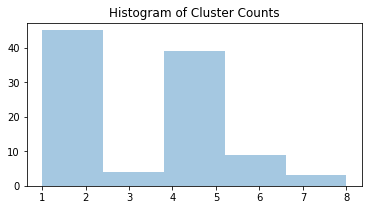

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns

ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [9]:
import os

job_name = kmeans.latest_training_job.name
model_key = "kmeans/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')

AttributeError: 'NoneType' object has no attribute 'name'

In [219]:
!pip install mxnet
import mxnet as mx

Kmeans_model_params = mx.ndarray.load('model_algo-1')

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [ ]:
## REMEMBER TO CLOSE SESSION!

In [221]:
import sagemaker
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)